In [1]:
from matplotlib import pyplot as plt
fig_width, fig_height = plt.rcParams['figure.figsize']

In [126]:
import scipy.io
import numpy as np

dataset = scipy.io.loadmat('dataset.mat')

times = dataset['t'][0]
eeg_data = dataset['data']  
image_ids = np.concatenate(dataset['triggers_all'].reshape(-1))
channels = np.concatenate(dataset['channels'][0])

print(f'EEG data shape: {eeg_data.shape}')

EEG data shape: (398, 64, 512)


In [110]:
image_vectors = {}
for img in set(image_ids):
    idx = [i for i, id in enumerate(image_ids) if id == img]
    avg = np.mean(eeg_data[image_ids == img], axis=0)  # average across trials
    image_vectors[img] = avg

imgs = sorted(image_vectors.keys())
mat = np.stack([image_vectors[img] for img in imgs])

In [111]:
from scipy.spatial.distance import pdist, squareform

rdms_time = []
for time_index, _ in enumerate(times):
    rdm = squareform(pdist(mat[:, :, time_index], metric='correlation'))  # 1 - corr
    rdms_time.append(rdm)

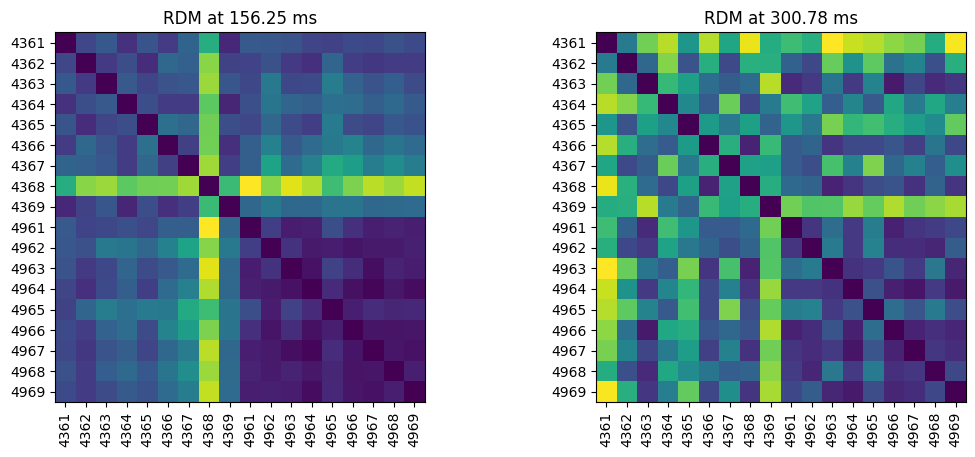

In [113]:

time_indices = [168, 205]

plt.figure(figsize=(len(time_indices) * fig_width, fig_height))

for i, time_index in enumerate(time_indices):
    rdm = squareform(pdist(mat[:, :, time_index], metric='correlation'))

    plt.subplot(1, len(time_indices), i + 1)
    plt.imshow(rdms_time[time_index])
    plt.xticks(np.arange(len(imgs)), labels=imgs, rotation=90)
    plt.yticks(np.arange(len(imgs)), labels=imgs)
    plt.title(f'RDM at {times[time_index]:.2f} ms')

plt.savefig('RDM time.pdf', bbox_inches='tight')
plt.show()

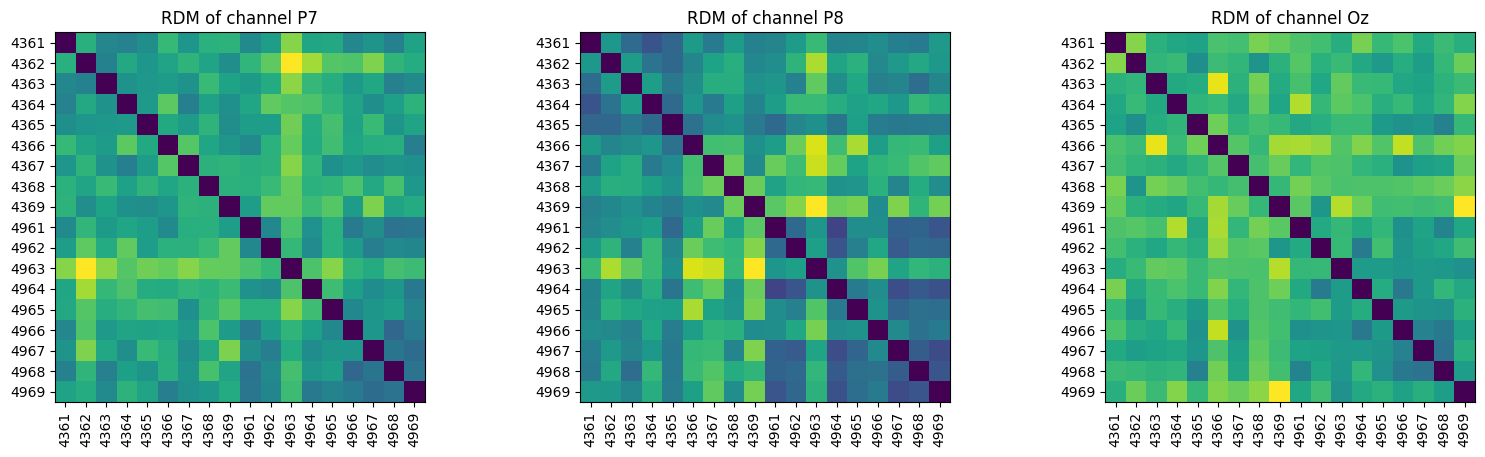

In [23]:
channel_indices = [14, 15, 62]

plt.figure(figsize=(len(channel_indices) * fig_width, fig_height))

for i, channel_index in enumerate(channel_indices):
    rdm = squareform(pdist(mat[:, channel_index, :], metric='correlation'))

    plt.subplot(1, len(channel_indices), i + 1)
    plt.imshow(rdm)
    plt.xticks(np.arange(len(imgs)), labels=imgs, rotation=90)
    plt.yticks(np.arange(len(imgs)), labels=imgs)
    plt.title(f'RDM of channel {channels[channel_index]}')

plt.savefig('RDM channel.pdf', bbox_inches='tight')
plt.show()

In [212]:
import os

image_paths = []
for dirpath, _, filenames in os.walk('Stimuli'):
    for filename in filenames:
        image_paths.append(os.path.join(dirpath, filename))


In [213]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [214]:
from PIL import Image

images = []
for path in image_paths:
    img = Image.open(path).convert('RGB')
    tensor = preprocess(img)
    images.append(tensor)

In [215]:
import torch

input_batch = torch.stack(images)

In [216]:
from cornet import cornet_s

model = cornet_s()
model.eval()

layers = ['V1', 'V2', 'V4', 'IT']

In [217]:
features = {}

def hook(layer_name):
    def fn(module, input, output):
        features[layer_name] = output.detach().reshape(output.shape[0], -1).numpy()
    return fn

# Register hooks
model.module.V1.register_forward_hook(hook('V1'))
model.module.V2.register_forward_hook(hook('V2'))
model.module.V4.register_forward_hook(hook('V4'))
model.module.IT.register_forward_hook(hook('IT'))

In [218]:
with torch.no_grad():
    _ = model(input_batch)

In [219]:
from scipy.spatial.distance import pdist, squareform

model_rdms = {}
for layer in layers:
    mat = features[layer]  # shape: (n_images, feature_dim)
    rdm = squareform(pdist(mat, metric='correlation'))  # 1 - corr
    model_rdms[layer] = rdm

In [220]:
from scipy.stats import spearmanr

rsa_time = {layer: [] for layer in layers}

for i, t in enumerate(times):
    for layer in layers:
        r, _ = spearmanr(rdms_time[i].flatten(), model_rdms[layer].flatten())
        rsa_time[layer].append(r)

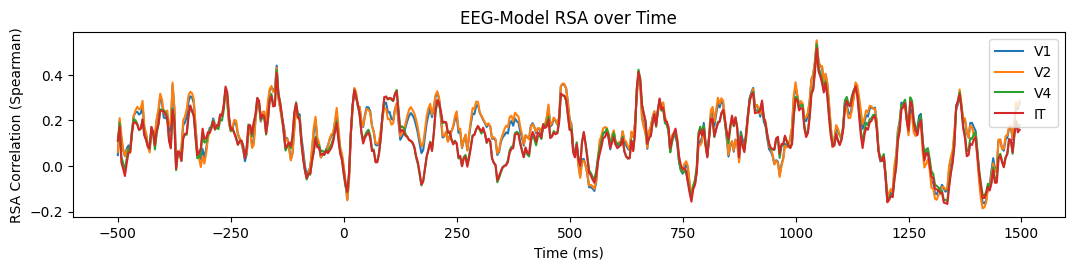

In [222]:
plt.figure(figsize=(2 * fig_width, 0.5 * fig_height))

for layer in layers:
    plt.plot(times, rsa_time[layer], label=layer)

plt.xlabel('Time (ms)')
plt.ylabel('RSA Correlation (Spearman)')
plt.title('EEG-Model RSA over Time')
plt.legend()
plt.savefig('RSA time.pdf', bbox_inches='tight')
plt.show()